In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
def data_analysis(df):
    ## grouping into int categories
    df["Sex"] = df["Sex"].replace({"male":0, "female":1})
    df["Embarked"] = df["Embarked"].replace({'C':0, 'S':1, 'Q':2})
    df["Cabin"] = df["Cabin"].apply(lambda x: 0 if x is np.nan else 1)

    ## handling names
    title_dict = {"Mr.":1, "Mrs.":2, "Mme.":2, "Miss.":3, "Mlle.":3, "Master.":4, "Dr.":5, "Rev.": 6}

    def name_lookup(name_str):
        for word in name_str.split():
            if word in title_dict.keys():
                return title_dict[word]
        return 0

    df["Name"] = df["Name"].apply(name_lookup)

    ## handling nans
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

    ## get dummies
    features = ["Pclass", "Name"]
    for f in features:
        df = pd.concat([df.drop(columns=f), pd.get_dummies(df[f], prefix=f)], axis=1)

    return(df)

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(z):
    return z * (1 - z)

def relu(x):
    return (x > 0) * x

def relu_derivative(z):
    return z > 0

def lrelu(x):
    return (x > 0) * x + (x < 0) * 0.01 * x

def lrelu_derivative(z):
    return (z > 0) - 0.01 * (z < 0)


class LayerNN:
    def __init__(self, shape, values=None, has_bias=True, activation="lrelu"):
        self.shape = shape
        self.values = values
        self.has_bias = has_bias
        
        if activation == "sigmoid":
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == "relu":
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == "lrelu":
            self.activation = lrelu
            self.activation_derivative = lrelu_derivative
        elif activation == "None":
            self.activation = None
            self.activation_derivative = None
            
    def set_values(self, values):
        if self.has_bias:
            self.values = np.hstack((np.ones((values.shape[0], 1)), values))
        else:
            self.values = values


class FeedForwardNn:
    def __init__(self):
        self.depth = -2
        self.shape = []
        self.layers = []
        self.weights = []
        
    def reset(self):
        self.__init__()
        
    def append_layer(self, layer):
        self.depth += 1
        self.shape.append(layer.shape)
        self.layers.append(layer)
        
    def reshape_vector(self, x):
        if len(x.shape) == 1:
            return x.reshape(-1, 1)
        else:
            return x
        
    def set_data(self, x, y):
        # input; np-like matrix; 1st index -- training example; 2nd index -- feature
        self.x = self.reshape_vector(x)
        # theoretical output; np-like vector; index -- training example
        self.y = self.reshape_vector(y)
    
    def init(self, x, y, hiden_shape, activations=None):
        self.set_data(x, y)
        # depth of the hidden layers
        self.depth = len(hiden_shape)
        # list of sizes of all the layers (input, hidden, and output) has depth+2 elements
        self.shape = [self.x.shape[1]] + list(hiden_shape) + [self.y.shape[1]]
        # init list of layers; has depth+2 elements
        self.init_layers(activations)
        # init list of weights; has depth+1 elements
        self.init_weights()
            
    def init_layers(self, activations=None):
        # input layer; has bias; does not have activation
        self.layers = [LayerNN(self.shape[0], activation="None")]
        # hidden layers; all have bias; default activation -- lrelu
        if activations == None:
            self.layers += [LayerNN(self.shape[l+1]) for l in range(self.depth)]
        else:
            self.layers += [LayerNN(self.shape[l+1], activation=activations[l]) for l in range(self.depth)]
        # output layer; does not have bias; default activation -- sigmoid
        self.layers += [LayerNN(self.shape[-1], has_bias=False, activation="sigmoid")]
        
    def init_weights(self):
        self.weights = []
        for l in range(self.depth+1):
            w = np.random.rand(self.layers[l].shape+self.layers[l].has_bias, self.layers[l+1].shape)
            self.weights.append(w)
        
    def train(self, n_iter=200, reg=0, learning_rate=0.01):
        self.layers[0].set_values(self.x)
        # training
        for i in range(n_iter):
            self.forward_propagate()
            self.back_propagate(reg, learning_rate)
        
    def forward_propagate(self):
        for l in range(self.depth+1):
            self.layers[l+1].set_values(self.layers[l+1].activation(self.layers[l].values @ self.weights[l]))
        
    def back_propagate(self, reg, learning_rate):
        # error at the output layer
        delta_1 = self.layers[-1].values - self.y
        # propagation of the errors depper to the hidden layers
        for l in range(self.depth):
            delta_2 = delta_1 @ self.weights[-l-1].T
            self.weights[-l-1] -= (self.layers[-l-2].values.T @ delta_1 / self.y.size +
                                   reg * self.weights[-l-1]) * learning_rate
            delta_2 *= self.layers[-l-2].activation_derivative(self.layers[-l-2].values)
            delta_1 = delta_2[:,self.layers[-l-2].has_bias:]
        self.weights[0] -= (self.layers[0].values.T @ delta_1 / self.y.size +
                            reg * self.weights[0]) * learning_rate

    def evaluate(self, x, y):
        # reinitialize all the h vectors
        self.layers[0].set_values(self.reshape_vector(x))
        self.forward_propagate()
        accuracy = (self.layers[-1].values < 0.5) ^ self.reshape_vector(y)
        return accuracy.sum() / accuracy.size
    
    def predict(self, x):
        # reinitialize all the h vectors
        self.layers[0].set_values(self.reshape_vector(x))
        self.forward_propagate()
        return self.layers[-1].values

In [15]:
## input
df_train = pd.read_csv("data/train.csv")
df_train = data_analysis(df_train)

## creating input and output dataframes
yf = df_train["Survived"]
xf = df_train.drop(columns=["PassengerId", "Survived", "Ticket"])
#sns.heatmap(xf.astype(float).corr(),vmax=1.0,  annot=True)

## normalizing
features = ["Age", "Fare"]
xf[features] = (xf[features] - xf[features].mean()) / xf[features].std()
print(xf.head())

   Sex       Age  SibSp  Parch      Fare  Cabin  Embarked  Pclass_1  Pclass_2  \
0    0 -0.565419      1      0 -0.502163      0       1.0         0         0   
1    1  0.663488      1      0  0.786404      1       0.0         1         0   
2    1 -0.258192      0      0 -0.488580      0       1.0         0         0   
3    1  0.433068      1      0  0.420494      1       1.0         1         0   
4    0  0.433068      0      0 -0.486064      0       1.0         0         0   

   Pclass_3  Name_0  Name_1  Name_2  Name_3  Name_4  Name_5  Name_6  
0         1       0       1       0       0       0       0       0  
1         0       0       0       1       0       0       0       0  
2         1       0       0       0       1       0       0       0  
3         0       0       0       1       0       0       0       0  
4         1       0       1       0       0       0       0       0  


In [19]:
frac_train = 0.75
m, n = xf.shape
m1_arr = np.arange(5, m, 1)
score_train_arr, score_test_arr = [], []

for m1 in m1_arr:
    print("\r{0} out of {1}".format(m1, m), end='\r')
    # randomly choosing samples
    row_sampler = np.random.choice(m, m1, replace=False)
    ynp_m1 = yf.loc[row_sampler].to_numpy()
    xnp_m1 = xf.loc[row_sampler, :].to_numpy()
    # splitting into train and test
    m1_train = int(m1 * frac_train)
    ynp_m1_train = ynp_m1[:m1_train]
    xnp_m1_train = xnp_m1[:m1_train, :]
    ynp_m1_test = ynp_m1[m1_train:m1]
    xnp_m1_test = xnp_m1[m1_train:m1, :]
    # training
    #ffnn = FeedForwardNn()
    #ffnn.init(xnp_m1_train, ynp_m1_train, [6, 3], activations=["lrelu", "lrelu"])
    #ffnn.train(n_iter=2000, reg=0.01, learning_rate=0.2)
    
    #'''
    ffnn = FeedForwardNn()
    ffnn.append_layer(LayerNN(n, has_bias=True, activation="none"))
    ffnn.append_layer(LayerNN(10, has_bias=True, activation="lrelu"))
    ffnn.append_layer(LayerNN(3, has_bias=True, activation="lrelu"))
    ffnn.append_layer(LayerNN(1, has_bias=False, activation="sigmoid"))
    ffnn.init_weights()
    ffnn.set_data(xnp_m1_train, ynp_m1_train)
    ffnn.train(n_iter=2000, reg=0.01, learning_rate=0.01)
    #'''
    
    score_train_arr.append(ffnn.evaluate(xnp_m1_train, ynp_m1_train))
    score_test_arr.append(ffnn.evaluate(xnp_m1_test, ynp_m1_test))

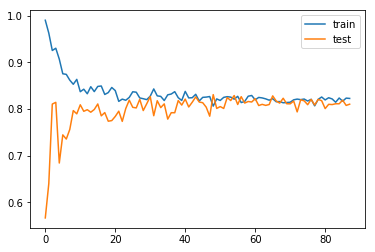

0.8295964125560538


In [23]:
n0 = 10
score_train_arr = np.array(score_train_arr)[:len(score_train_arr) // n0 * n0]
score_test_arr = np.array(score_test_arr)[:len(score_test_arr) // n0 * n0]
fig, fax = plt.subplots()
fax.plot(np.mean(score_train_arr.reshape(-1, n0), axis=1), label="train")
fax.plot(np.mean(score_test_arr.reshape(-1, n0), axis=1), label="test")
plt.legend()
plt.show()
print(ffnn.evaluate(xnp_m1_test, ynp_m1_test))

In [ ]:
## making real predictions
df_test = pd.read_csv("data/test.csv")
df_test = data_analysis(df_test)
xf = df_test.drop(columns=["PassengerId", "Ticket"])
features = ["Age", "Fare"]
xf[features] = (xf[features] - xf[features].mean()) / xf[features].std()
prediction_f = pd.DataFrame(ffnn.predict(xf.to_numpy()) > 0.5, columns=["Survived"])

## saving the file
prediction_f = pd.concat([df_test["PassengerId"], prediction_f], axis=1).astype(int)
prediction_f.info()
print(prediction_f.head())
prediction_f.to_csv("data/prediction_fromScratch_feedForwardNn_advanced.csv", index=False)